In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay

Öncelikle kullanacağımız kütüphaneleri çağırdık.

In [3]:
data = pd.read_csv("winequality.csv")

df = pd.DataFrame(data)

df

df.info()

df.describe()

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Sonrasında kullanacağımız veri setini Python'a okutup bir veri çerçevesi (dataframe) oluşturduk.


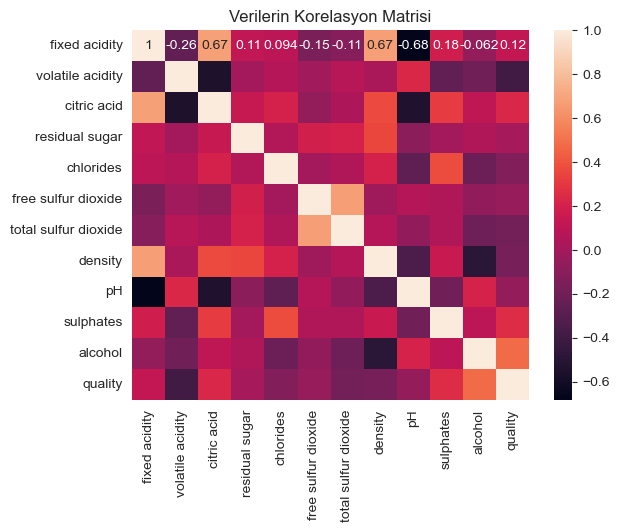

In [5]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True)
plt.title('Verilerin Korelasyon Matrisi')
plt.show()

Özelliklerin birbiriyle arasındaki korelasyona bakmak için bir matris oluşturduk. 0'a yakın olanlar aralarında pek ilişki bulunmadığı anlamına gelmektedir. Bu yüzden 0'a yakın olanları bulup çıkarmamız gerekir.

In [28]:
df.corr(numeric_only=True)["quality"].sort_values(ascending=False)

quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64

In [6]:
threshold = 0.1
korelasyon = abs(corr_matrix["quality"])
filtered_data = korelasyon[korelasyon>threshold]
filtered_data

fixed acidity           0.124052
volatile acidity        0.390558
citric acid             0.226373
chlorides               0.128907
total sulfur dioxide    0.185100
density                 0.174919
sulphates               0.251397
alcohol                 0.476166
quality                 1.000000
Name: quality, dtype: float64

In [7]:
kullanma = korelasyon[korelasyon<0.1]
kullanma

residual sugar         0.013732
free sulfur dioxide    0.050656
pH                     0.057731
Name: quality, dtype: float64

Bu düşük korelasyona sahip değerler kullanmayacağımız kısım olacak.

In [8]:
kullanma_frame = kullanma.to_frame()
kullanma_frame

,quality
residual sugar,0.013732
free sulfur dioxide,0.050656
pH,0.057731


In [9]:
row_names = kullanma_frame.index
row_names_list = list(row_names)
row_names_list.append('quality')
print(row_names_list)

['residual sugar', 'free sulfur dioxide', 'pH', 'quality']


Verinin tipini değiştirip bir liste şekline getirdik.

In [19]:
X = data.loc[:, ['residual sugar', 'free sulfur dioxide', 'pH', 'quality']]
encoder = LabelEncoder()
for i in X.columns:
    X[i] = encoder.fit_transform(X[i])
X


,residual sugar,free sulfur dioxide,pH,quality
0,10,11,63,2
1,22,25,32,2
2,17,15,38,2
3,10,17,28,3
4,10,11,63,2
...,...,...,...,...
1594,11,32,57,2
1595,15,40,64,3
1596,17,29,54,3
1597,11,32,69,2


In [22]:
y = data.loc[:, ["quality"]]
y = encoder.fit_transform(y.values.ravel())
y

array([2, 2, 2, ..., 3, 2, 3], dtype=int64)

X ve y değişkenleri atayıp verileri eğitmek ve test etmek için ön işlemden geçirdik.

In [29]:
steps = [('scaler', StandardScaler()),
('dec_tree', DecisionTreeClassifier())]

pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)
params = {"dec_tree__criterion":['gini', 'entropy'],
         "dec_tree__max_depth":np.arange(3, 15)
         }

from sklearn.model_selection import GridSearchCV
for cv in range(3,10):
    cv_grid = GridSearchCV(pipeline, param_grid=params,cv=cv)
    cv_grid.fit(X_train, y_train)
    print("%d fold score: %3.2f" %(cv,cv_grid.score(X_test, y_test)))
    print("Best parameters: ", cv_grid.best_params_)

3 fold score: 1.00
Best parameters:  {'dec_tree__criterion': 'gini', 'dec_tree__max_depth': 3}
4 fold score: 1.00
Best parameters:  {'dec_tree__criterion': 'gini', 'dec_tree__max_depth': 3}
5 fold score: 1.00
Best parameters:  {'dec_tree__criterion': 'gini', 'dec_tree__max_depth': 3}
6 fold score: 1.00
Best parameters:  {'dec_tree__criterion': 'gini', 'dec_tree__max_depth': 3}
7 fold score: 1.00
Best parameters:  {'dec_tree__criterion': 'gini', 'dec_tree__max_depth': 3}
8 fold score: 1.00
Best parameters:  {'dec_tree__criterion': 'gini', 'dec_tree__max_depth': 3}
9 fold score: 1.00
Best parameters:  {'dec_tree__criterion': 'gini', 'dec_tree__max_depth': 3}


En iyi kriter gini ve maksimum derinlik 3 olduğuna karar veririz.

In [30]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Veriyi standartlaştırdık.

In [31]:
print("X_train_scaled shape:",X_train.shape)
print("X_test_scaled shape:",X_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

X_train_scaled shape: (1279, 4)
X_test_scaled shape: (320, 4)
y_train shape: (1279,)
y_test shape: (320,)


In [27]:
karar_agaci = DecisionTreeClassifier(criterion='gini', max_depth=3)
karar_agaci.fit(X_train, y_train)
y_pred = karar_agaci.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00       130
           3       1.00      1.00      1.00       128
           4       1.00      1.00      1.00        44
           5       1.00      1.00      1.00         6

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320



Çalıştırdığımızda F1 skoru ile modelimizi doğruladık.